# Final Project DSI

In [ ]:
#     import os
# os.chdir(r'C:\Users\bakar\OneDrive\Desktop\Python')
# os.getcwd()

In [ ]:
from datetime import datetime
from dotenv import load_dotenv
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
from xgboost import XGBClassifier           
from xgboost import plot_importance
import tensorflow as tf
import torch
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import random
import re
import xgboost as xgb



In [ ]:
# Show full column width, all columns and all rows
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [ ]:
# Load the data 

df_raw =  pd.read_csv('C:/Users/NEWPC/DSI/team_project/Project/data.csv', header = 0)

df_raw.head()  # Notes: There is issue with features names having spaces. We will fix this in the next step.

In [ ]:
# cleaning the data/column names

def custom_clean_column_names(df):
    """
    Cleans DataFrame column names using custom rules:
    - Remove leading/trailing spaces
    - Replace '%' with 'pct'
    - Replace '/' with ' over '
    - Replace '-' with '_'
    - Remove '?' symbol
    - Replace 'Yuan ¥' with 'Yuan'
    - Replace '(' with '_'
    - Remove ')'
    - Replace spaces with '_'
    - Collapse multiple underscores
    """
    
    df_cleaned = df.copy()     # Create a copy to avoid modifying original   
    cleaned = []
    for col in df.columns:
        col = col.strip()                      # Remove leading/trailing spaces
        col = col.replace('%', 'pct')          # Replace % with pct
        col = col.replace('/', ' over ')       # Replace / with over
        col = col.replace('-', '_')            # Replace - with _
        col = col.replace('?', '')             # Remove ?
        col = col.replace('Yuan ¥', 'Yuan')    # Remove ¥
        col = col.replace("'", '')             # Remove '
        col = col.replace('(', '_')            # Replace ( with _
        col = col.replace(')', '')             # Remove )
        col = re.sub(r'\s+', '_', col)         # Replace spaces with _
        col = re.sub(r'_+', '_', col)          # Collapse multiple underscores
        cleaned.append(col)
    df_cleaned.columns = cleaned
    return df_cleaned

df_bank = custom_clean_column_names(df_raw)

In [ ]:
# df_bank.head()

# Data Inspection:

In [ ]:
# Data types

df_bank.info()  

# Notes: the data types are float64 and int64 which are suitable for our analysis. 
# No further conversion is needed.      

In [ ]:
# Missing values count
print(df_bank.isnull().sum())  #  No missing values found in the dataset.

In [ ]:
# Duplicate rows count
print("Number of duplicate rows:", df_bank.duplicated().sum()) # No duplicate rows found in the dataset.

In [ ]:
# Column  Count, Mean,Std Dev, Min, Max, 25%, 50% and 75% percentiles

df_bank.describe()

In [ ]:
# Check class distribution
print(df_bank['Bankrupt'].value_counts())  # Notes: There is an imbalance in the target variable.

In [ ]:
# Separate features and target
X = df_bank.drop(columns=['Bankrupt'])
y = df_bank['Bankrupt']                                                                                                                                                                                         

# Upsampling the minority class

In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_bank[df_bank['Bankrupt'] == 0]
df_minority = df_bank[df_bank['Bankrupt'] == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,                  # sample with replacement
    n_samples=len(df_majority),    # match majority count
    random_state=42                # reproducibility
)

# Combine back
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle if needed
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_balanced['Bankrupt'].value_counts()

In [ ]:
# Split Features and Target

X = df_balanced.drop(columns=['Bankrupt'])
y = df_balanced['Bankrupt']

# Principal Component Analysis (PCA): 
Principal Component Analysis (PCA) is a great choice for dimensionality reduction when we have a large number of features and want to retain the most informative ones for our model.

- Standardization is a crucial preprocessing step, especially before applying PCA, as PCA is highly sensitive to the    scale of the features.
- scaler = StandardScaler(): An instance of the scaler is created.
- scaler.fit_transform(X): This does two things:
- fit: It calculates the mean and standard deviation for every feature (column) in X.
- transform: It then scales the data so that each feature has a mean of 0 and a standard deviation of 1. The standardized data is stored in X_scaled.

PCA transforms the original features into a new, smaller set of features (called Principal Components) while attempting to retain as much information (variance) as possible.

- pca = PCA(n_components=0.95): This is the key setting. Instead of specifying a fixed number of components (e.g., n_components=10), setting it to 0.95 (which is between 0 and 1.0) tells PCA to select the minimum number of components necessary to capture 95% of the total variance in the original data.

- pca.fit_transform(X_scaled):

- fit: It calculates the principal components from the standardized data X_scaled.

- transform: It projects the data onto these selected principal components, resulting in the reduced dataset X_pca.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# step1: Separate features and target
X = df_balanced.drop(columns=['Bankrupt'])  # Replace 'target' with your actual label column
y = df_balanced['Bankrupt']

#step-2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step3 : Apply PCA to retain 95% variance
#pca = PCA(n_components=0.95)
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_scaled)

# Check how many components were retained
print(f"Number of components retained: {pca.n_components_}")

In [ ]:
 # visualize the PCA projection

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [ ]:
# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Generate component names
component_names = [f'PC{i+1}' for i in range(pca.n_components_)]
print("Principal Component Names:")
print(component_names)



In [ ]:
import pandas as pd
import numpy as np

# Assuming X is ouroriginal feature matrix (before scaling)
original_feature_names = X.columns

# Create a DataFrame showing feature contributions to each principal component
loadings = pd.DataFrame(
    pca.components_.T,  # transpose so rows = features, columns = PCs
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=original_feature_names
)

# Display top contributing features for each component
for i in range(pca.n_components_):
    print(f"\nTop features for PC{i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(10))

In [ ]:
import matplotlib.pyplot as plt

# Plot Top Feature Loadings per Principal Component

# Create loadings DataFrame
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns  # original feature names
)

# Plot top 10 features for each component
num_components = pca.n_components_
fig, axes = plt.subplots(nrows=num_components, ncols=1, figsize=(10, 4 * num_components))

if num_components == 1:
    axes = [axes]  # ensure iterable

for i, ax in enumerate(axes):
    pc = f'PC{i+1}'
    top_features = loadings[pc].abs().sort_values(ascending=False).head(10)
    top_features.plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title(f'Top 10 Feature Loadings for {pc}')
    ax.set_xlabel('Absolute Loading Value')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Feature Selection via PCA Loadings

import numpy as np

# Set a threshold for "significant" contribution
loading_threshold = 0.45 # You can tune this value Threshold: Start with 0.3 or 0.4; lower it if you want more features, raise it for stricter selection

# Create a boolean mask for features with high absolute loadings in any PC
high_loading_mask = (loadings.abs() >= loading_threshold).any(axis=1)

# Select those feature names
selected_features = loadings.index[high_loading_mask].tolist()

print(f"Selected {len(selected_features)} features:")
print(selected_features)

# Subset your original DataFrame
X_selected = X[selected_features]
print(f"Shape of original feature set: {X.shape}")
print(f"Shape of selected feature set: {X_selected.shape}")

In [ ]:
X_selected.head(5)

# Correlation matrix

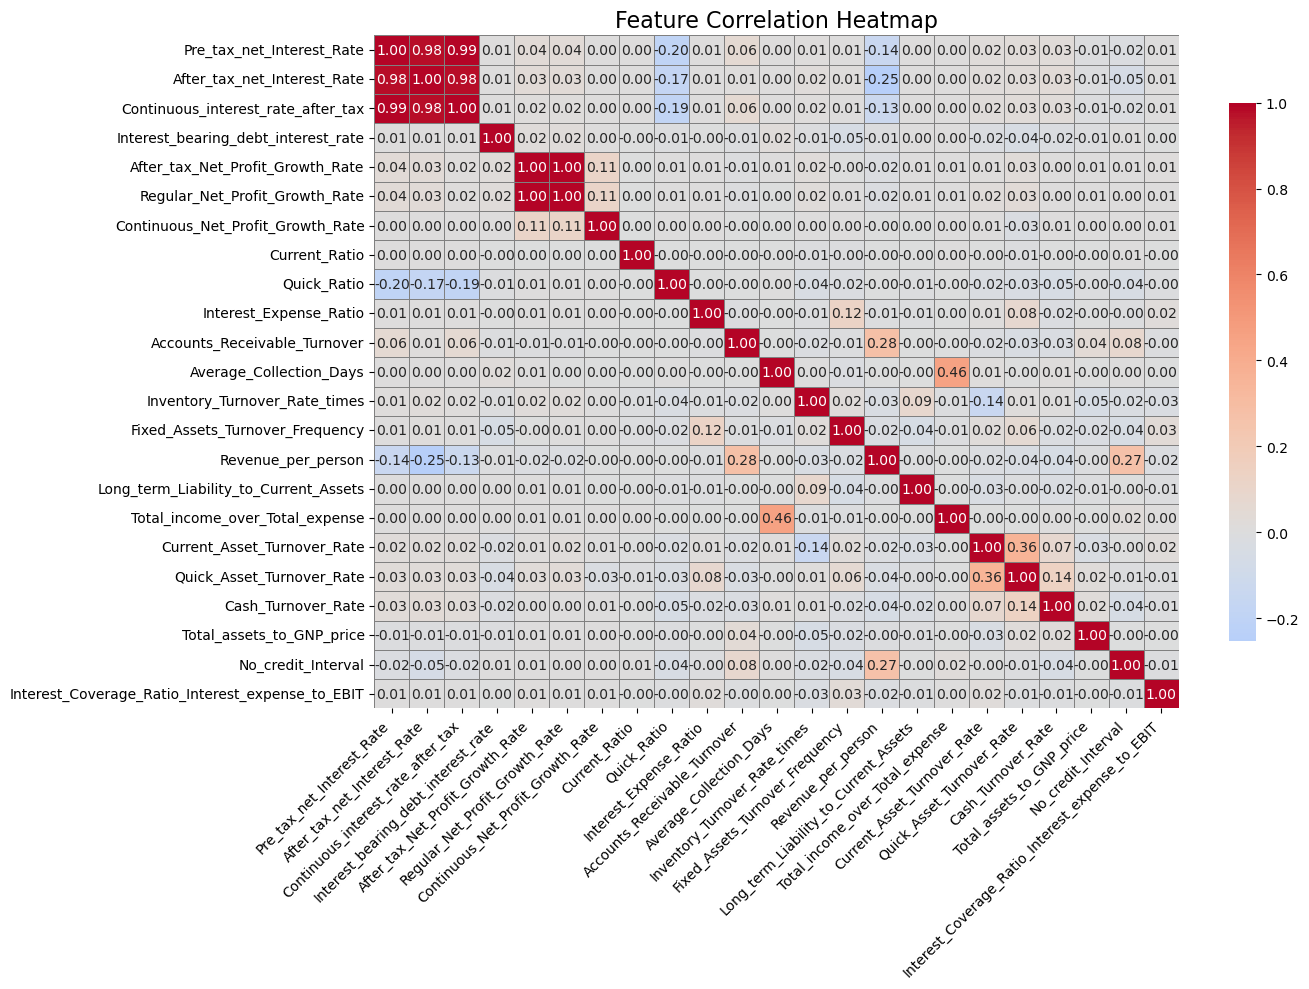

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the target column (adjust name if needed)
features_only = X_selected

# Compute correlation matrix
corr_matrix = features_only.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, linecolor='gray', cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



Notes: we can drop some corelated colums because of highly corelated to Operating_Profit_Rate: 
- Pre-tax_net_Interest_Rate	
- After-tax_net_Interest_Rate	
- Continuous_interest_rate_(after_tax)


## Variance in Feature Selection
What Is Variance in Feature Selection?: 
It performs a simple but effective technique for feature selection based on the variance of each feature. The goal is to remove features that are constant or nearly constant, as they provide little to no useful information for a machine learning model.

Only keep features whose values vary enough — specifically, with a variance greater than 0.1 (example)
This helps: 
- Remove uninformative features that don’t change much across samples.
- Reduce noise and improve model generalization.
- Speed up training by trimming irrelevant dimensions.
 
 This is an effective technique for feature selection based on the variance of each feature. The goal is to remove features that are constant or nearly constant, as they provide little to no useful information for a machine learning model.

- selector.get_support(): This method returns a boolean mask (a list of True/False values). True indicates a retained feature, and False indicates a discarded feature.

- This mask is used to select the corresponding column names from the original DataFrame's columns (X.columns).

- Finally, a new DataFrame X_selected is created by subsetting the original data X using the list of selected_features. This ensures the new DataFrame retains the original structure, including column names.

- It's also remove the highly correlated feature: the less important feature is dropped

- The output prints the number and names of the features that were kept and then displays the resulting DataFrame X_selected.

- Note: Features with zero variance (e.g., a column where every value is the same) are always removed by default, regardless of the threshold setting, as they have no predictive power.

In [52]:
# Variance-Based Feature Selection

from sklearn.feature_selection import VarianceThreshold

# Set threshold (e.g., 0.1)
selector = VarianceThreshold(threshold= 0.1)

# Fit on training data
X_var_filtered = selector.fit_transform(X)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()

print(f"Selected {len(selected_features)} features with variance > 0.1:")
print(selected_features)

# Subset original data
X_selected = X[selected_features]

X_selected.head(5)

Selected 24 features with variance > 0.1:
['Operating_Expense_Rate', 'Research_and_development_expense_rate', 'Interest_bearing_debt_interest_rate', 'Revenue_Per_Share_Yuan', 'Total_Asset_Growth_Rate', 'Net_Value_Growth_Rate', 'Current_Ratio', 'Quick_Ratio', 'Total_debt_over_Total_net_worth', 'Accounts_Receivable_Turnover', 'Average_Collection_Days', 'Inventory_Turnover_Rate_times', 'Fixed_Assets_Turnover_Frequency', 'Revenue_per_person', 'Allocation_rate_per_person', 'Quick_Assets_over_Current_Liability', 'Cash_over_Current_Liability', 'Inventory_over_Current_Liability', 'Long_term_Liability_to_Current_Assets', 'Current_Asset_Turnover_Rate', 'Quick_Asset_Turnover_Rate', 'Cash_Turnover_Rate', 'Fixed_Assets_to_Assets', 'Total_assets_to_GNP_price']


,Operating_Expense_Rate,Research_and_development_expense_rate,Interest_bearing_debt_interest_rate,Revenue_Per_Share_Yuan,Total_Asset_Growth_Rate,Net_Value_Growth_Rate,Current_Ratio,Quick_Ratio,Total_debt_over_Total_net_worth,Accounts_Receivable_Turnover,Average_Collection_Days,Inventory_Turnover_Rate_times,Fixed_Assets_Turnover_Frequency,Revenue_per_person,Allocation_rate_per_person,Quick_Assets_over_Current_Liability,Cash_over_Current_Liability,Inventory_over_Current_Liability,Long_term_Liability_to_Current_Assets,Current_Asset_Turnover_Rate,Quick_Asset_Turnover_Rate,Cash_Turnover_Rate,Fixed_Assets_to_Assets,Total_assets_to_GNP_price
0,1.830526e-04,3.700000e+08,0.000325,0.048233,5.940000e+09,0.000461,0.010006,0.009541,0.006411,0.000621,0.010169,4.274304e-04,0.000762,0.030604,0.004938,0.010029,3.864594e-03,0.000296,0.002972,0.000103,0.000112,4.130000e+09,0.133730,0.001185
1,1.082358e-04,3.570000e+08,0.000316,0.037751,5.040000e+09,0.000365,0.004917,0.003691,0.021261,0.000532,0.011893,2.300519e-04,0.000198,0.009709,0.006339,0.004114,4.685335e-04,0.002431,0.005762,0.000117,0.000103,1.100000e+09,0.414241,0.001562
2,9.200000e+09,1.340000e+09,0.000165,0.054373,8.030000e+09,0.000503,0.009531,0.008583,0.008214,0.000797,0.007940,3.336135e-04,0.000281,0.013857,0.007189,0.008664,6.899712e-03,0.002595,0.012503,0.000118,0.000115,8.720000e+08,0.307178,0.009815
3,4.588456e-04,0.000000e+00,0.000714,0.003010,6.270000e+09,0.000425,0.013488,0.001934,0.009874,0.000174,0.036358,1.530000e+08,0.000165,0.028075,0.033107,0.001822,6.840000e+09,0.030461,0.005915,0.003741,0.000557,1.740000e+09,0.043647,0.015418
4,9.680000e+08,1.490000e+09,0.000430,0.035362,1.493468e-04,0.000619,0.009923,0.006894,0.017560,0.001057,0.005978,9.170000e+09,0.000175,0.031879,0.028188,0.007927,4.093959e-03,0.005507,0.017198,0.000281,0.000236,1.109893e-04,0.289930,0.004239


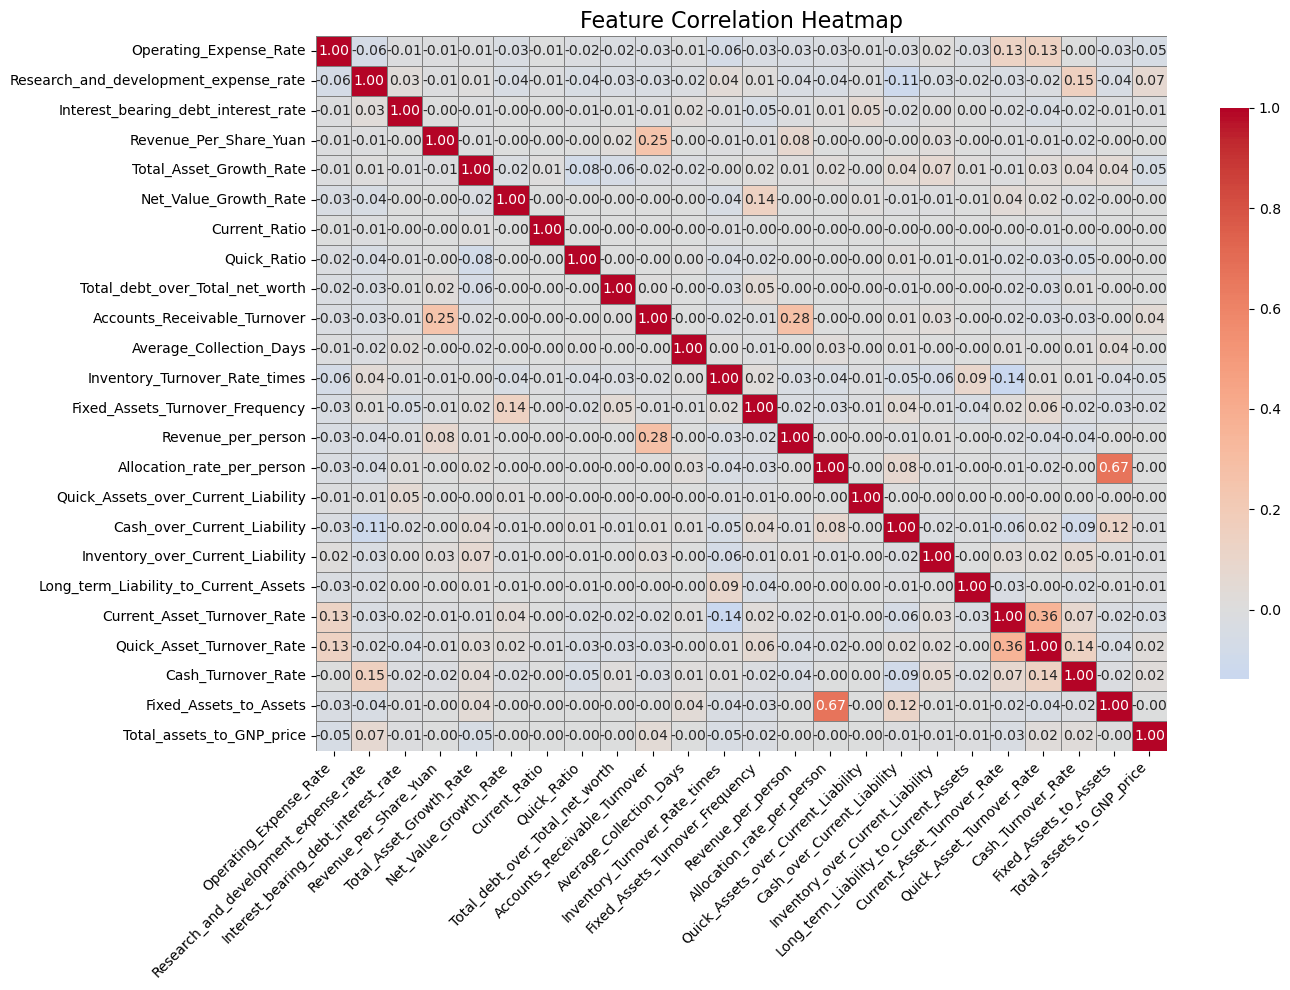

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the target column (adjust name if needed)
features_only = X_selected

# Compute correlation matrix
corr_matrix = features_only.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, linecolor='gray', cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

Notes: Why This Matters : The Variance-Based Feature Selection removed the the less important corelated feaures
• 	High correlation (> 0.8) between features may indicate redundancy
• 	Negative correlation can reveal inverse relationships
• 	Helps guide feature selection, dimensionality reduction, and model interpretability

When features are correlated in machine learning, they often carry redundant information, which can cause problems for some models, particularly linear ones, by making model parameters unstable and difficult to interpret. Conversely, models like tree-based algorithms are less affected performance-wise, but interpretability can still be an issue. While removing correlated features can simplify the model and improve performance, the decision depends on the specific model, the goal (prediction vs. interpretability), and the nature of the correlation. The 

# Applying Machine learning Model : 

.1- Logistic Regression.

.2- Random Forest.

.3- XGBoost. 

Then we will compare  and select the best model for turning "


In [53]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

   

🔹 Confusion Matrix:
[[452 208]
 [285 375]]

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.68      0.65       660
           1       0.64      0.57      0.60       660

    accuracy                           0.63      1320
   macro avg       0.63      0.63      0.63      1320
weighted avg       0.63      0.63      0.63      1320

🔹 ROC AUC Score: 0.682


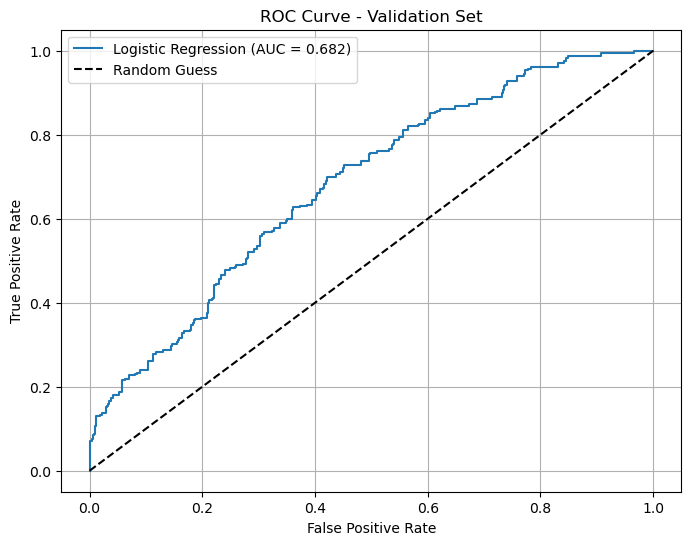

In [55]:
# 1-: Logistic Regression

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Train logistic regression
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred = logreg.predict(X_val_scaled)
y_val_proba = logreg.predict_proba(X_val_scaled)[:, 1]

# Confusion matrix
print("🔹 Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Classification report
print("\n🔹 Classification Report:")
print(classification_report(y_val, y_val_pred))

# ROC AUC score
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"🔹 ROC AUC Score: {roc_auc:.3f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix:
[[657   3]
 [  0 660]]

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       660
           1       1.00      1.00      1.00       660

    accuracy                           1.00      1320
   macro avg       1.00      1.00      1.00      1320
weighted avg       1.00      1.00      1.00      1320

 ROC AUC Score: 1.000


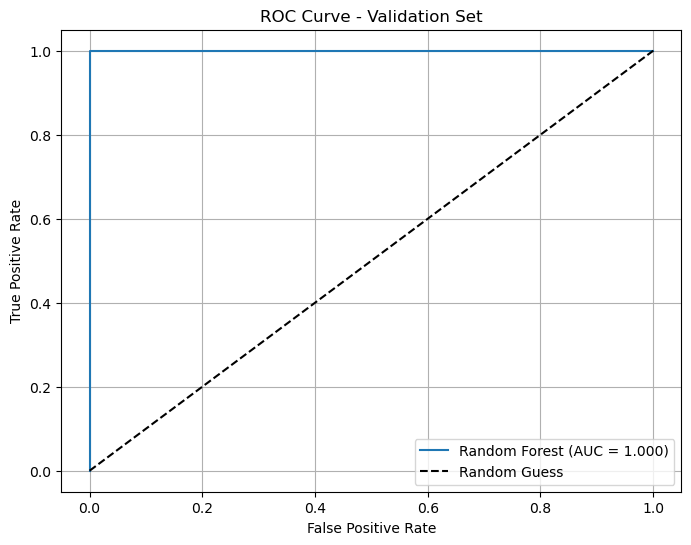

In [56]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Train Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_scaled)
y_val_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf))

# Classification report
print("\n Classification Report:")
print(classification_report(y_val, y_val_pred_rf))

# ROC AUC score
roc_auc_rf = roc_auc_score(y_val, y_val_proba_rf)
print(f" ROC AUC Score: {roc_auc_rf:.3f}")

# ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\NEWPC\miniconda3\envs\dsi_participant\lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[645  15]
 [  0 660]]

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       660
           1       0.98      1.00      0.99       660

    accuracy                           0.99      1320
   macro avg       0.99      0.99      0.99      1320
weighted avg       0.99      0.99      0.99      1320

ROC AUC Score: 1.000


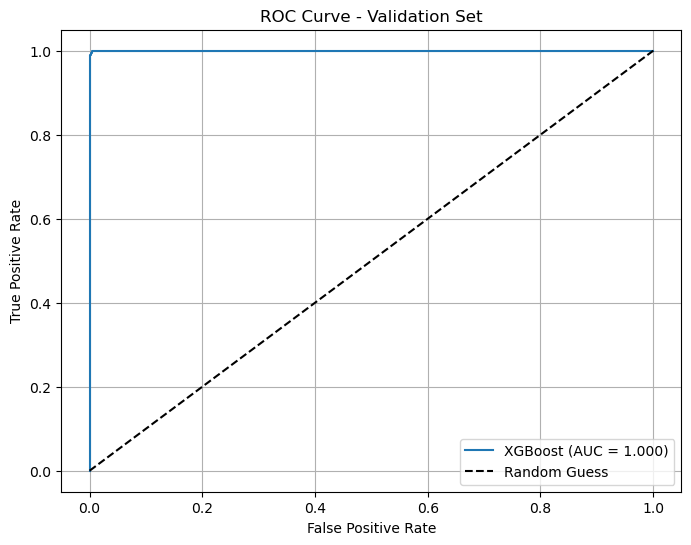

In [57]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_xgb))

# Classification report
print("\n Classification Report:")
print(classification_report(y_val, y_val_pred_xgb))

# ROC AUC score
roc_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)
print(f"ROC AUC Score: {roc_auc_xgb:.3f}")

# ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_val_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix:
[[659   1]
 [  0 660]]

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       660
           1       1.00      1.00      1.00       660

    accuracy                           1.00      1320
   macro avg       1.00      1.00      1.00      1320
weighted avg       1.00      1.00      1.00      1320

 ROC AUC Score: 1.000


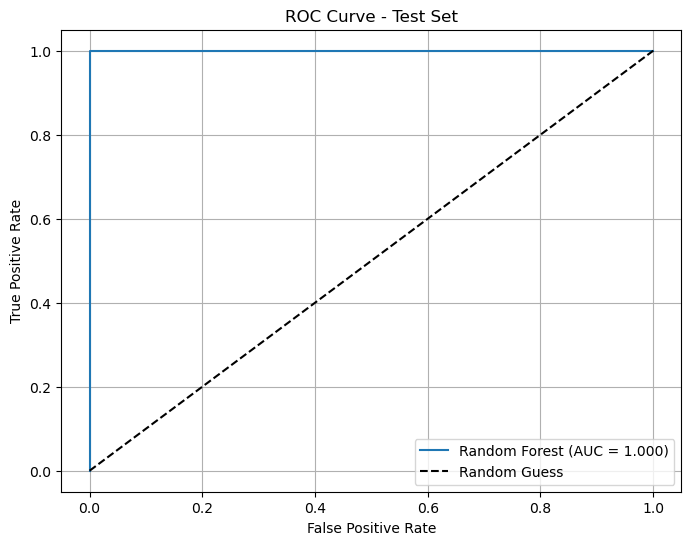

In [60]:
# Random Forest Evaluation on Test Set


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict on test set
y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_test_pred))

# ROC AUC score
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f" ROC AUC Score: {roc_auc_test:.3f}")

# ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f"Random Forest (AUC = {roc_auc_test:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True)
plt.show()

![Confusion Matrix](confusion_matrix.png)

# Model Comparison:

- Logistic regression: 
Accuracy = 0.63 -- F1-score-class_1= 00.60 -- Recall(class_1) = 0.57 -- ROC_AUC= 0.68

- XBoost Classifier:
Accuracy = 1 -- F1-score-class_1= 1 -- Recall(class_1) = 1 -- ROC_AUC= 3

- Random Forest Classifier:
Accuracy = 0.99 -- F1-score-class_1= 1 -- Recall(class_1) = 1 -- ROC_AUC= 15

In conclusion the best model is the Random forest:


Best Model: Random Forest
- Why: Perfect recall, precision, and ROC AUC on validation set
- Use Case Fit: Ideal for bankruptcy prediction where missing a true positive (false negative) is costly
- Validate on test set to confirm generalization

#  Hyperparameter tuning for Random Forest

In [ ]:
# step 1: Import and Define Parameter Grid

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced'],
    'max_features': ['sqrt', 'log2']
}

In [63]:
# step2: Initialize Grid Search

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # or 'roc_auc', 'recall', depending on your priority
    verbose=2,
    n_jobs=-1
)

# 3. Fit on Scaled Training Data
grid_search.fit(X_train_scaled, y_train)

# 4. Best Parameters and Model
print(" Best Parameters:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
🔹 Best Parameters:
{'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [64]:
# Step5 5. Evaluate on Validation Set

y_val_pred = best_rf.predict(X_val_scaled)
y_val_proba = best_rf.predict_proba(X_val_scaled)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("\n Classification Report:")
print(classification_report(y_val, y_val_pred))

print(" ROC AUC Score:", roc_auc_score(y_val, y_val_proba))



Confusion Matrix:
[[658   2]
 [  0 660]]

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       660
           1       1.00      1.00      1.00       660

    accuracy                           1.00      1320
   macro avg       1.00      1.00      1.00      1320
weighted avg       1.00      1.00      1.00      1320

 ROC AUC Score: 0.9999999999999999


# Full Pipeline with Transformer and Tuned Random Forest

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Define numeric features (replace with your actual column names)
numeric_features = X_train.columns.tolist()

# Preprocessing: scale numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

# Tuned Random Forest model
rf_best = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

# Full pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', rf_best)
])

# Fit pipeline on training data
rf_pipeline.fit(X_train, y_train)

# Predict on validation or test set
y_val_pred = rf_pipeline.predict(X_val)
y_val_proba = rf_pipeline.predict_proba(X_val)[:, 1]

# Model explainability

In [ ]:
import shap
import pandas as pd

# Step 1: Extract model and preprocessor
rf_model = rf_pipeline.named_steps['classifier']
preprocessor = rf_pipeline.named_steps['preprocessing']

# Step 2: Transform X_train and get correct feature names
X_train_transformed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

# Step 3: Wrap transformed data in a DataFrame with correct shape and names
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Step 4: Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train_transformed)

# Step 5: Plot feature importance (bar plot with values)
shap.summary_plot(shap_values[1], X_train_df, plot_type="bar")

# Exporting the Pipeline with

In [ ]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("Bankruptcy_RF_Pipeline")

with mlflow.start_run(run_name="Final_RF_Model"):
    # Log model
    mlflow.sklearn.log_model(
        rf_pipeline,
        artifact_path="rf_pipeline_model",
        registered_model_name="Bankruptcy_RF_Pipeline"
    )

    # Log parameters
    mlflow.log_params({
        "n_estimators": 300,
        "max_depth": None,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "max_features": "sqrt",
        "class_weight": "balanced"
    })



    # Log metrics

    mlflow.log_metrics({
        "accuracy": 1.00,
        "precision": 1.00,
        "recall": 1.00,
        "f1_score": 1.00,
        "roc_auc": 1.00
    })   

2025/11/16 12:54:51 INFO mlflow.tracking.fluent: Experiment with name 'Bankruptcy_RF_Pipeline' does not exist. Creating a new experiment.
2025/11/16 12:54:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 12:55:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Bankruptcy_RF_Pipeline'.
Created version '1' of model 'Bankruptcy_RF_Pipeline'.
